# Exercise 1.1

### Evaluation of defined integrals and test of the (pseudo)random number generator



We test the random number generator by computing defined integrals  $\langle r \rangle = \int_0^1 r dr = 1/2$ and $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$. Integrals are calculated by estimating the average value $⟨f⟩(b - a)$ of the integrand on the integration interval $(a;b)$ by evaluating $f(r)$ where $r$ is **uniformly distributed** on $(a;b)$.

Results are computed using **data blocking** gathering the single measures $x_i$ into $N = 100$ blocks of $L = 100$ measures each. Averages $X_j$ are computed for each block, resulting in a global average $⟨X_j⟩$ with statistical error $\sqrt{\frac{⟨X^2⟩ - ⟨X⟩^2}{N-1}}$.

The aim of data blocking is to lower the correlation between measures by subdividing the sample into single uncorrelated experiments

<ipython-input-1-231cbc0d3c89>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("mean.dat", delim_whitespace=True, header=None, names=["mean", "error_mean", "variance", "error_variance"])


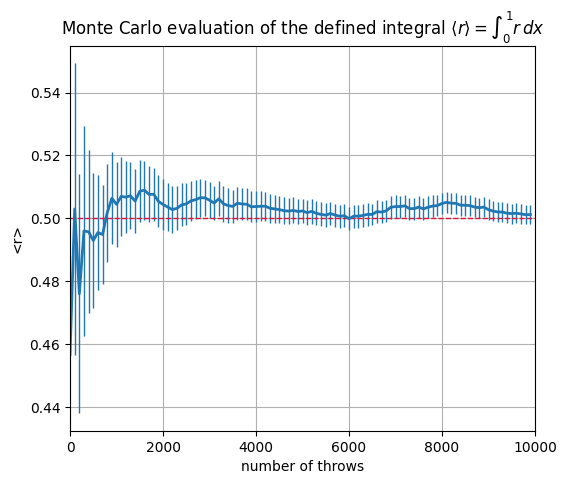

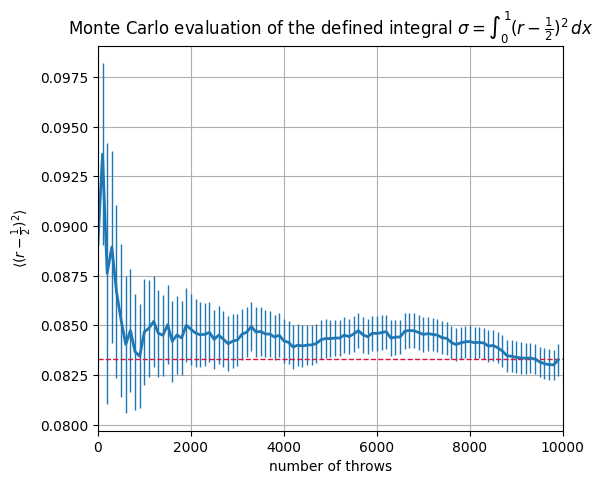

,mean,error_mean,variance,error_variance
0,0.456646,0.000000,0.089040,0.000000
1,0.502985,0.046338,0.093619,0.004579
2,0.476028,0.037979,0.087620,0.006556
3,0.496012,0.033475,0.088946,0.004822
4,0.495708,0.025931,0.086714,0.004351
...,...,...,...,...
95,0.501519,0.003173,0.083166,0.000772
96,0.501633,0.003142,0.083080,0.000769
97,0.501401,0.003119,0.083029,0.000763
98,0.501149,0.003097,0.083014,0.000755


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

N = 100     #blocks
M = 10**4   #throws
L = int(M/N)

#input data:
df = pd.read_csv("mean.dat", delim_whitespace=True, header=None, names=["mean", "error_mean", "variance", "error_variance"])
x = np.arange(N)
x*=L

#<r> integration plot
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.errorbar(x,df['mean'],yerr=df['error_mean'], linewidth=2, elinewidth=1)
ax.set(xlabel = 'number of throws', ylabel = r'<r>', title = r'Monte Carlo evaluation of the defined integral $\langle r \rangle = \int_{0}^{1} r \,dr$')
ax.set_xlim(0,10000)
ax.axhline(0.5, color='crimson', linestyle = '--', linewidth = 1)
ax.grid(True)

plt.show()
plt.close()

#<(r-0.5)^2> integration plot
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.errorbar(x,df['variance'],yerr=df['error_variance'], linewidth=2, elinewidth=1)
ax.set(xlabel = 'number of throws', ylabel = r'$\langle (r - \frac{1}{2})^2 \rangle$', title = r'Monte Carlo evaluation of the defined integral $\sigma = \int_{0}^{1} (r - \frac{1}{2})^2 \,dr$')
ax.set_xlim(0,10000)
ax.axhline(1/12, color='crimson', linestyle = '--', linewidth = 1)
ax.grid(True)

plt.show()
plt.close()
df

### $\chi ^2$

We now aim to gustify the asumption that the random uniform generator works correctly. We use Pearson's $\chi^2$ test to measure the error between observations, $O_i$, and expected values, $E_i$:
$$\chi^2 = \sum_{i} \frac{\left( O_i - E_i \right)^2}{E_i}$$

We divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. We know the number of expected events observed in each sub-interval after $n$ throws according to a uniform distribution: $E_i = np = n\times 1/M= n/M$. We count how many times each extracted number falls into the observed interval 100 times.
We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq M$ (the number of sub-intervals).

Results are shown with an histogram for the obtained $\chi^2$ values, which are distributed with a pronounced peak around the 100 value, indeed.

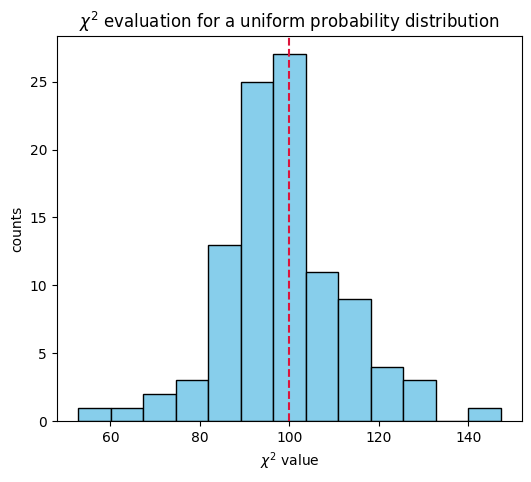

Chi squared: 98 +- 14


In [ ]:
#input data:
df = pd.read_csv("chi2.dat", header=None, names=["chi2"])

#plot hist:
nbin = 12
bin_width =  (df['chi2'].max() - df['chi2'].min())/nbin
bin_edges = np.arange(df['chi2'].min(), df['chi2'].max() + bin_width, bin_width)
bin_centers = bin_edges[:-1] + bin_width / 2

closest = np.argmin(np.abs(bin_centers - 100))
shift = 100 - bin_centers[closest]
bin_edges += shift

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.hist(df['chi2'], bins=bin_edges, color='skyblue', edgecolor='black')
ax.set(xlabel = r'$\chi^2$ value', ylabel = r'counts', title = r'$\chi^2$ evaluation for a uniform probability distribution')
ax.axvline(100, color='crimson', linestyle = '--')

plt.show()
plt.close()

print('Chi squared: ' + str(round(df['chi2'].mean())) + r' +- ' + str(round(df['chi2'].std())))

# Exercise 1.2

### Sampling of an exponential and Cauchy-Lorentz distribution using the inverse CDF method

We extend the NSL Random generator code to test the Central Limit Theorem, according to which, the averages of random variables distributed with i.i.d. distributions with finite variance are themselves distributed more and more like a normal distribution (centered on the true average value), indipendently from their starting distribution, as the number of averages increases.

In order to do so, we define new functions to extract numbers distributed with:


*   exponential distribution</font>, $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$
*   Cauchy-Lorentz distribution</font> $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-∞;+\infty]$

By using the inverse cumulative distribution function method to invert $F(x) = \int_0^xdx'p(x')$:


*   $x_{exp} = \frac{-log(1-F(x))}{λ}$
*   $x_{CL} = \mu + Γ*tan(\pi*(F(x) - 1/2))$

Where, to get $x$, we uniformly extract $F(x)$





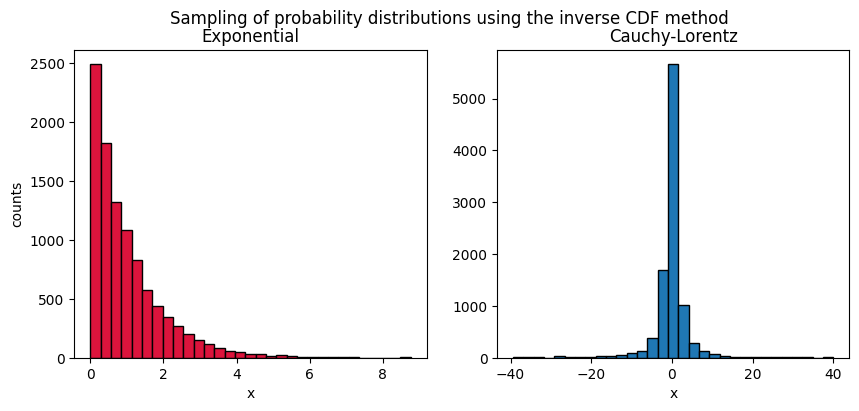

In [ ]:
#input data:
df_exp = pd.read_csv("exp_distribution.dat", header=None, names=["exp"])
df_CL = pd.read_csv("cauchy_distribution.dat", header=None, names=["cauchy-lorentz"])

#plot distributions:
fig, ax = plt.subplots(1,2, figsize=(10,4))

nbin = 31
bin_width =  (0.5*df_CL['cauchy-lorentz'].std())/nbin
bin_edges = np.arange(df_CL['cauchy-lorentz'].mean() - 0.25*df_CL['cauchy-lorentz'].std(), df_CL['cauchy-lorentz'].mean() + 0.25*df_CL['cauchy-lorentz'].std() + bin_width, bin_width)

ax[0].hist(df_exp['exp'], bins = nbin, color='crimson', edgecolor='black')
ax[1].hist(df_CL['cauchy-lorentz'], bins=bin_edges, edgecolor='black')
ax[0].set(xlabel = 'x', ylabel = 'counts', title = 'Exponential')
ax[1].set(xlabel = 'x', title = 'Cauchy-Lorentz')

plt.suptitle('Sampling of probability distributions using the inverse CDF method')

plt.show()
plt.close()

### Test of the CLT with uniform, exponential, and Cauchy-Lorentz distribution

We can now test the CLT by adding averages of different distributions. We can see that as $N$ increases, the histogram slowly resembles a Gaussian. This is shown by a fit.

The Cauchy-Lorentz distribution does not have finite variance, therefore does not converge to a Gaussian. It is nontheless a stable distribution, so it itself is its own attractor, as shown by a fit with a Lorentz distribution.

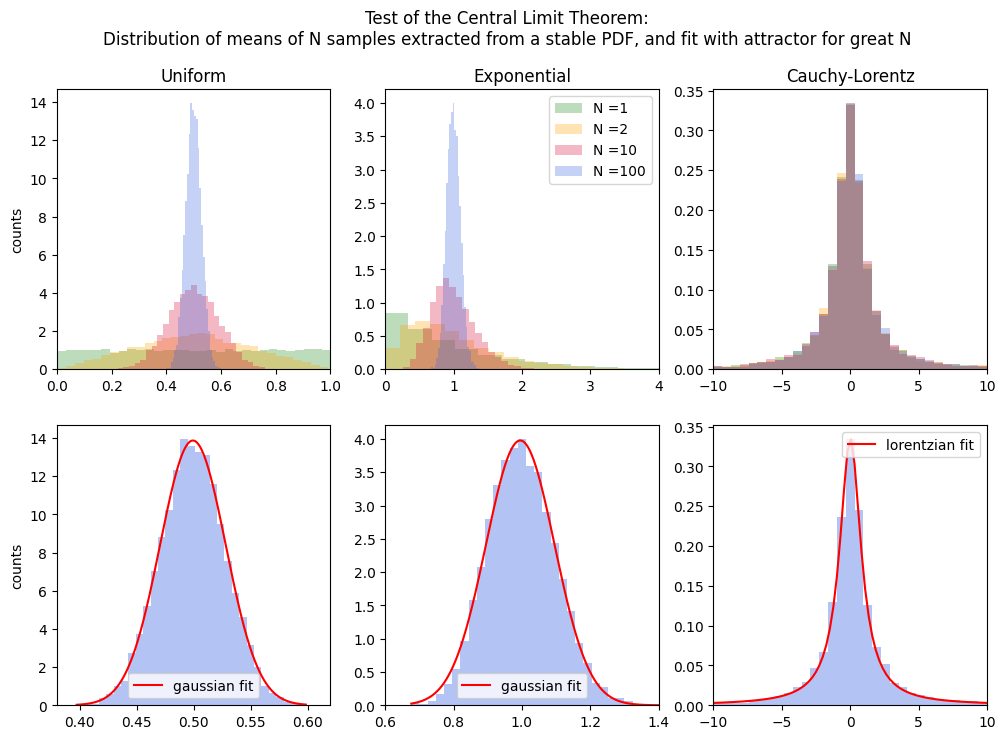

,uniform_1,uniform_2,uniform_10,uniform_100,exp_1,exp_2,exp_10,exp_100,CL_1,CL_2,CL_10,CL_100
0,0.264464,0.559578,0.472117,0.451011,1.935800,0.574123,0.909115,0.817723,-48.113100,-0.684366,1.608070,1.226620
1,0.534136,0.171030,0.591528,0.465472,1.806550,0.468350,1.227310,0.970164,0.918428,-6.533770,-0.244419,0.204534
2,0.304792,0.569385,0.528416,0.497813,0.689101,0.900003,0.946352,1.076670,0.530074,-1.879470,0.244639,1.840610
3,0.896646,0.127580,0.489880,0.519242,2.150430,1.123160,1.417410,1.115920,-1.506930,0.861622,1.067140,1.967380
4,0.769676,0.326410,0.456870,0.495323,1.277490,1.157630,1.019410,0.955835,-1.871640,1.013720,-2.366470,18.065700
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.178611,0.467205,0.488949,0.528190,0.981384,1.403120,0.915766,1.077300,-3.111970,0.945897,-0.830875,-1.771980
9996,0.710214,0.915986,0.552253,0.516863,0.195335,0.413257,1.427580,0.936331,0.069229,-1.145190,0.375437,0.647871
9997,0.958632,0.672821,0.619518,0.484272,0.037253,1.456120,1.212630,0.820262,-0.273154,-3.641320,0.866467,0.297789
9998,0.078638,0.395232,0.474378,0.491254,1.915240,0.413579,0.899879,0.974045,0.527835,-4.806100,1.729380,0.157750


In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import cauchy

def gauss(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def C_L(x, x0, gamma):
    return cauchy.pdf(x, x0, gamma)

#input data:
df = pd.read_csv("CLT.dat", sep=' ')

#plot distributions:
col_list = ['forestgreen', 'orange', 'crimson', 'royalblue']
N = ['1', '2', '10', '100']
distr_type = ['uniform_', 'exp_', 'CL_']

nbin = 31
counts = [[],[],[]]
bins = [[],[],[]]

fig, ax = plt.subplots(2,3, figsize=(12,8))

for i in range(len(distr_type)):

  if i == 2:
    nbin = np.arange(-10, 10 + 20/31, 20/31)

  for j in range(len(N)):
    ax[0,i].hist(df[distr_type[i]+N[j]], label='N ='+N[j], bins = nbin, color = col_list[j], alpha = 0.3, density = True)

  counts[i], bins[i], _ = ax[1,i].hist(df[distr_type[i]+N[3]], bins = nbin, color = col_list[3], alpha = 0.4, density = True)
  bins[i] = (bins[i][:-1] + bins[i][1:]) / 2

  #fit:
  if i != 2:
    #popt, _ = curve_fit(gauss, bin_centers, counts, p0=[df[distr_type[i]+N[3]].mean(), df[distr_type[i]+N[3]].mean()].std())
    popt, _ = curve_fit(gauss, bins[i], counts[i])
    x_fit = np.linspace(df[distr_type[i]+N[3]].min(), df[distr_type[i]+N[3]].max(), 10000)
    ax[1,i].plot(x_fit, gauss(x_fit, *popt), 'r-', label='gaussian fit')
  else:
    #popt, _ = curve_fit(C_L, bin_centers, counts, p0=[df[distr_type[i]+N[3]].mean(), 1.0])
    popt, _ = curve_fit(C_L, bins[i], counts[i])#RIMUOVERE LISTE??
    x_fit = np.linspace(df[distr_type[i]+N[3]].min(), df[distr_type[i]+N[3]].max(), 10000)
    ax[1,i].plot(x_fit, C_L(x_fit, *popt), 'r-', label='lorentzian fit')


ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
ax[0,0].set(ylabel = 'counts', title='Uniform')
ax[0,1].set(title='Exponential')
ax[0,2].set(title='Cauchy-Lorentz')
ax[1,0].set(ylabel = 'counts')

ax[0,0].set_xlim(0,1)
ax[1,0].set_xlim(0.38,0.62)
ax[0,1].set_xlim(0,4)
ax[1,1].set_xlim(0.6,1.4)
ax[0,2].set_xlim(-10,10)
ax[1,2].set_xlim(-10,10)


plt.suptitle(r"Test of the Central Limit Theorem:" + "\n" + "Distribution of means of N samples extracted from a stable PDF, and fit with attractor for great N")

plt.show()
plt.close()

df

# Exercise 1.3

### Generation of random-uniform angles without using PI

Finally, we re-enact Buffon's experiment for the estimation of $\pi$. We simulate needles of length "L" being thrown on a sheet of paper subdivided by parallel equidistant (with distance $d$) lines. The main challenge here is to simulate the needle's casual orientation $θ \in [0, 2\pi]$ without using \pi.

To do so, i settled on simulating the sine of a uniformly distributed angle theta as the inclination of the segment between a random point inside the unitary circle and the origin:

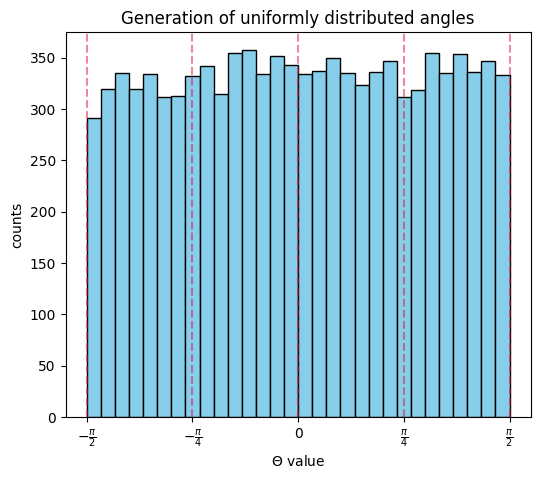

,sin_theta,theta
0,-0.592332,-0.633950
1,0.952815,1.262378
2,-0.896124,-1.110957
3,0.933297,1.203487
4,0.934222,1.206072
...,...,...
9995,-0.079803,-0.079888
9996,-0.277822,-0.281526
9997,0.379090,0.388813
9998,0.919231,1.166123


In [ ]:
#input data:
df = pd.read_csv("theta.dat", header=None, names=["sin_theta"])
df['theta'] = np.arcsin(df['sin_theta'])


#plot hist:
nbin = 30

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.hist(df['theta'], bins=nbin, color='skyblue', edgecolor='black')
ax.set(xlabel = r'$\Theta$ value', ylabel = r'counts', title = r'Generation of uniformly distributed angles')

my_ticks = [-np.pi/2 + k*np.pi/4 for k in range(5)]
ax.set_xticks(my_ticks)
ax.set_xticklabels([r"$- \frac{\pi}{2}$", r"$- \frac{\pi}{4}$", "0", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
for i in my_ticks:
  ax.axvline(i, color='crimson', linestyle='--', alpha=0.5)

plt.show()
plt.close()

df

$\pi$ can now be computed by the probability of the needle hitting a line: $P = \frac{2L}{\pi d}$

<ipython-input-31-4ac588a8f7ed>:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("PI.dat", delim_whitespace=True, header=None, names=["PI", "error"])


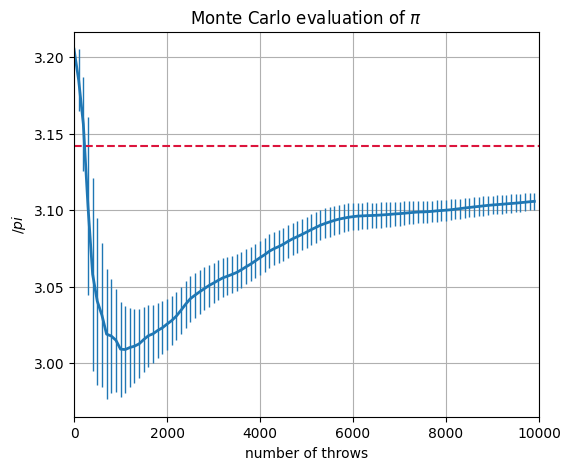

,PI,error
0,3.20513,0.000000
1,3.18484,0.020286
2,3.15629,0.030865
3,3.10251,0.058037
4,3.05804,0.063231
...,...,...
95,3.10457,0.005871
96,3.10486,0.005817
97,3.10516,0.005765
98,3.10547,0.005715


In [ ]:

N = 100
M = 10**4
L = int(M/N)

#input data:
df = pd.read_csv("PI.dat", delim_whitespace=True, header=None, names=["PI", "error"])
x = np.arange(N)
x*=L

#<r> integration plot
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.errorbar(x,df['PI'],yerr=df['error'], linewidth=2, elinewidth=1)
ax.set(xlabel = 'number of throws', ylabel = r'$/pi$', title = r'Monte Carlo evaluation of $\pi$')
ax.set_xlim(0,M)
ax.grid(True)
ax.axhline(np.pi, color='crimson', linestyle = '--')

plt.show()
plt.close()

df